In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
%matplotlib inline

data_path = '../AlerceDHtest/datasets/ZTF'

In [2]:
path = data_path+'/broker_reals.json'
with open(path, "r") as f:
        dataset = json.load(f)  

In [3]:
dataset["query_result"][0].keys()

dict_keys(['_id', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])

In [4]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# zero point as in ZTF zp'= zp +2.5*log10(Texp)
# and clip between 23-28 as in ZTF paper https://arxiv.org/abs/1902.01872
def get_zero_point(stamp, aperture_mag, exp_time=30.0):
    stamp_shape = stamp.shape
    mask = createCircularMask(stamp_shape[0], stamp_shape[1], center=np.array(stamp_shape)/2, radius=8)
    extracted_mask = np.multiply(mask, stamp)
    count_photometry = np.nansum(extracted_mask)
    #beacuse it is diff image
    #if count_photometry < 0:
    #    return [], [], np.nan
    residual_image = stamp - extracted_mask
    zero_point = aperture_mag + 2.5*np.log10(np.clip(count_photometry, a_min=1e-4, a_max=None))#/exp_time)
    zero_point = np.clip(zero_point, a_min=23, a_max=28)
    return zero_point, residual_image, count_photometry

In [5]:
KEY_TO_GET = 'zero_point'#'magapbig'#
data_dict = {"g":{}, "r":{}, "i":{}}
filters_ls = list(data_dict.keys())
for alert in dataset["query_result"]:
    #dict_in_stamp = {'science_stamp':None, 'filter': None, 'fwhm': None, 'mjd': None, 'field': None, 'object_id': None}
    stamp = alert['cutoutDifference']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data
    #dict_in_stamp['science_stamp'] = img
    #zero point
    aperture_mag = alert["candidate"]["magap"]
    #dict_in_stamp["magap"] = aperture_mag
    zero_point, res, c = get_zero_point(img, aperture_mag)
    #dict_in_stamp['zero_point'] = 24.5#zero_point
    
    variable_to_retrieve = zero_point#alert["candidate"][KEY_TO_GET]#
    fid = alert["candidate"]["fid"]
    
    if KEY_TO_GET in data_dict[filters_ls[fid-1]].keys():
        data_dict[filters_ls[fid-1]][KEY_TO_GET].append(variable_to_retrieve)
    else:
        data_dict[filters_ls[fid-1]][KEY_TO_GET] = [variable_to_retrieve,]

In [6]:
#all data to array
#all_data_array = []
#for channel in data_dict.keys():
#    try:
#        all_data_array.append(data_dict[channel][KEY_TO_GET])
#    except:
#        pass

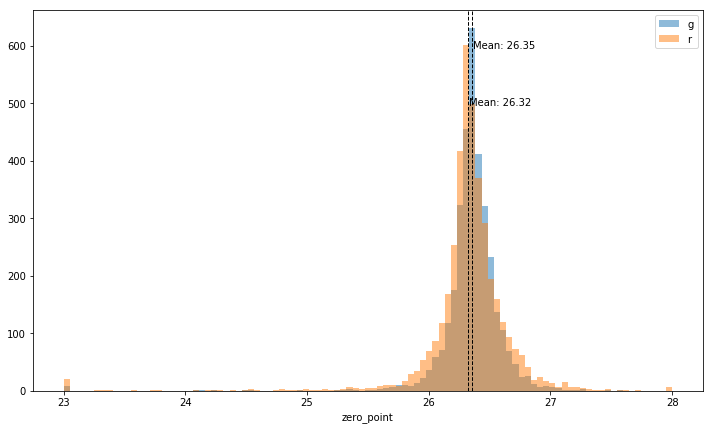

In [7]:
plt.figure(figsize=(12,7))
for i, channel in enumerate(filters_ls):
    try:
        x = np.array(data_dict[channel][KEY_TO_GET])
        plt.hist(x, label=channel, alpha=0.5, bins = np.linspace(23,28,100))#, density=True)
        plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
        _, max_ = plt.ylim()
        plt.text(x.mean() + 1e-2, 
         (max_ - max_/10)-i*1e2, 
         'Mean: {:.2f}'.format(x.mean()))
    except:
        pass
plt.xlabel(KEY_TO_GET)
#plt.xlim([25,27.5])
plt.legend()
plt.show()
    